# 🚀 KAN-PINN JAX GPU Optimization - Levitador Magnético

## Identificación de Parámetros Físicos con Differential Evolution en GPU

Este notebook implementa un sistema completo de optimización para identificar los parámetros físicos del levitador magnético usando:

- **JAX**: Computación vectorizada en GPU
- **Differential Evolution**: Optimización metaheurística completamente paralelizada
- **GPU Acceleration**: Evaluación de toda la población en un solo paso

### 📋 Contenido del Notebook:

1. **Configuración del Entorno** (Colab GPU, dependencias)
2. **Carga de Datos** (formato estándar y KAN-PINN)
3. **Transferencia a GPU** (pandas → JAX arrays)
4. **Modelo Físico** (vectorizado en JAX)
5. **Differential Evolution** (optimización GPU)
6. **Visualización de Resultados**
7. **Guardado y Descarga**
8. **Comparativa GPU vs CPU** (opcional)

### ⚡ Instrucciones de Uso:

1. **Activar GPU en Colab**: `Runtime > Change runtime type > GPU (T4)`
2. **Ejecutar todas las celdas**: `Runtime > Run all`
3. El notebook se auto-configura y usa datos demo del repositorio

---

## 1️⃣ Configuración del Entorno

Instalamos dependencias y verificamos que tenemos acceso a GPU.

In [1]:
# Verificar GPU disponible
import subprocess
import sys

print("🔍 Verificando GPU...")
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], text=True)
    print("✅ GPU detectada:")
    print(gpu_info)
except:
    print("⚠️  No se detectó GPU. Este notebook funcionará en CPU (más lento).")
    print("   Para activar GPU: Runtime > Change runtime type > GPU")

🔍 Verificando GPU...
✅ GPU detectada:
Tue Jan  6 19:44:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------

In [2]:
# Instalar dependencias necesarias
print("📦 Instalando dependencias...\n")

import sys
import platform

IN_COLAB = 'google.colab' in sys.modules
IS_WINDOWS = platform.system() == 'Windows'

# 1. Resolver conflictos de dependencias (NumPy vs TensorFlow/JAX)
!pip install -q "numpy<2.1.0" "ml-dtypes>=0.4.0,<0.5.0"

# 2. Instalar JAX según el entorno
if IN_COLAB:
    print("☁️  Detectado Google Colab: Instalando JAX con soporte TPU/GPU...")
    # En Colab, JAX suele venir preinstalado, pero forzamos actualización compatible
    !pip install -q "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
elif IS_WINDOWS:
    print("🪟  Detectado Windows: La instalación de JAX con GPU es experimental.")
    print("    Intentando instalación estándar (CPU). Para GPU en Windows, consulte la doc oficial.")
    # En Windows nativo, instalamos la versión CPU por defecto para evitar errores
    # Si el usuario tiene configuración experta (WSL2), puede descomentar la línea de CUDA
    !pip install -q jax jaxlib
    # !pip install -q "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
else:
    print("🐧  Detectado Linux/Mac: Instalando JAX estándar...")
    !pip install -q "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# 3. Otras librerías
!pip install -q scipy pandas matplotlib tqdm

print("\n✅ Dependencias instaladas correctamente")

📦 Instalando dependencias...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tensorflow 2.19.0 requires ml-dtypes<1.0.0,>=0.5.1, but you have ml-dtypes 0.4.1 which is incompatible.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tensorstore 0.1.80 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
☁️  Detectado Google Colab: Instalando JAX con soporte TPU/GPU...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 60.3 MB/s eta 0:00:00

✅ Dependencias instaladas correctamente


In [3]:
# Verificar instalación de JAX y dispositivos disponibles
import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.lax import scan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import time
from datetime import datetime
from tqdm.auto import tqdm
from functools import partial

# Configurar JAX para usar float64 si es necesario (opcional, por defecto float32 es más rápido)
# jax.config.update("jax_enable_x64", True)

# Verificar dispositivos JAX
print("\n🖥️  Dispositivos JAX disponibles:")
devices = jax.devices()
for i, device in enumerate(devices):
    print(f"  [{i}] {device}")

# Forzar uso de GPU si está disponible
if any('gpu' in str(d).lower() for d in devices):
    print("\n✅ GPU disponible - Los cálculos se ejecutarán en GPU")
else:
    print("\n⚠️  GPU no disponible - Los cálculos se ejecutarán en CPU")

# Configurar matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("\n✅ Imports completados correctamente")


🖥️  Dispositivos JAX disponibles:
  [0] cuda:0

⚠️  GPU no disponible - Los cálculos se ejecutarán en CPU

✅ Imports completados correctamente


## 2️⃣ Clonar Repositorio (Opcional)

Si estamos en Colab y queremos usar los datos del repositorio, clonamos el repo.

In [4]:
# Verificar si ya estamos en el repo o necesitamos clonarlo
import os

REPO_URL = "https://github.com/JRavenelco/levitador-benchmark.git"
REPO_DIR = "levitador-benchmark"

if os.path.exists(REPO_DIR):
    print(f"✅ Repositorio ya existe en {REPO_DIR}")
    if os.getcwd().split(os.sep)[-1] != REPO_DIR:
        %cd {REPO_DIR}
elif os.path.exists("levitador_benchmark.py"):
    print("✅ Ya estamos en el directorio del repositorio")
    REPO_DIR = "."
else:
    print(f"📥 Clonando repositorio desde {REPO_URL}...")
    !git clone {REPO_URL}
    %cd {REPO_DIR}
    print("✅ Repositorio clonado correctamente")

# Mostrar estructura de datos disponibles
print("\n📁 Archivos de datos disponibles:")
if os.path.exists("data"):
    !ls -lh data/*.txt 2>/dev/null || echo "  (No hay archivos .txt en data/)"
    if os.path.exists("data/sesiones_kan_pinn"):
        print("\n📁 Datos KAN-PINN disponibles:")
        !ls -lh data/sesiones_kan_pinn/*.txt 2>/dev/null || echo "  (No hay archivos)"
else:
    print("  ⚠️  Carpeta 'data' no encontrada")

📥 Clonando repositorio desde https://github.com/JRavenelco/levitador-benchmark.git...
Cloning into 'levitador-benchmark'...
remote: Enumerating objects: 1214, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 1214 (delta 172), reused 216 (delta 115), pack-reused 918 (from 1)
Receiving objects: 100% (1214/1214), 18.03 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/levitador-benchmark
✅ Repositorio clonado correctamente

📁 Archivos de datos disponibles:
-rw-r--r-- 1 root root 323K Jan  6 19:46 data/datos_levitador_20251024_162706.txt
-rw-r--r-- 1 root root 323K Jan  6 19:46 data/datos_levitador.txt
-rw-r--r-- 1 root root 154K Jan  6 19:46 data/kan_validation_data.txt

📁 Datos KAN-PINN disponibles:
-rw-r--r-- 1 root root 201K Jan  6 19:46 data/sesiones_kan_pinn/dataset_chirp_20251217_210058.txt
-rw-r--r-- 1 root root 169K Jan  6 19:46 data/sesiones_kan_pinn/dataset_constante_20251217_205611.txt

## 3️⃣ Funciones de Carga de Datos

Funciones flexibles para cargar datos en diferentes formatos:
- **Formato estándar**: `datos_levitador.txt` (columnas: t, y, i, u, ...)
- **Formato KAN-PINN**: `sesiones_kan_pinn/dataset_*.txt` (columnas: t, y, y_obs, dy_obs, i, u, yd)

In [5]:
# Regex pattern for whitespace separation
WHITESPACE_PATTERN = r"\s+"

def load_standard_data(filepath, subsample=1):
    """
    Carga datos en formato estándar del levitador.

    Formato esperado (columnas separadas por tabs/espacios):
    t [s]  |  y [m]  |  i [A]  |  u [V]  |  dy [m/s]  |  yd [m]

    Args:
        filepath: Ruta al archivo de datos
        subsample: Factor de submuestreo (1=todos, 10=cada 10 puntos)

    Returns:
        dict con arrays numpy: 't', 'y', 'i', 'u', 'dy' (opcional), 'yd' (opcional)
    """
    print(f"\n📂 Cargando datos desde: {filepath}")

    # Detectar si tiene encabezado
    with open(filepath, 'r') as f:
        first_line = f.readline().strip()
        skiprows = 1 if (first_line.startswith('#') or not first_line[0].isdigit()) else 0

    # Cargar con pandas para manejo robusto
    if skiprows > 0:
        df = pd.read_csv(filepath, sep='\\s+', comment='#', header=None)
    else:
        df = pd.read_csv(filepath, sep='\\s+', header=None)

    # Submuestreo
    if subsample > 1:
        df = df.iloc[::subsample].reset_index(drop=True)
        print(f"   Submuestreo: {subsample}x (quedaron {len(df)} puntos)")

    # Extraer columnas
    data = {
        't': df.iloc[:, 0].values.astype(np.float32),
        'y': df.iloc[:, 1].values.astype(np.float32),
        'i': df.iloc[:, 2].values.astype(np.float32),
        'u': df.iloc[:, 3].values.astype(np.float32),
    }

    # Columnas opcionales
    if df.shape[1] > 4:
        data['dy'] = df.iloc[:, 4].values.astype(np.float32)
    if df.shape[1] > 5:
        data['yd'] = df.iloc[:, 5].values.astype(np.float32)

    print(f"✅ Datos cargados: {len(data['t'])} muestras")
    print(f"   Columnas: {list(data.keys())}")
    print(f"   Rango temporal: {data['t'][0]:.3f} - {data['t'][-1]:.3f} s")

    return data


def load_kanpinn_data(filepath, subsample=1):
    """
    Carga datos en formato KAN-PINN.

    Formato esperado (con encabezado comentado):
    # Columnas: t y y_obs dy_obs i u yd
    t [s]  |  y [m]  |  y_obs [m]  |  dy_obs [m/s]  |  i [A]  |  u [V]  |  yd [m]

    Args:
        filepath: Ruta al archivo de datos KAN-PINN
        subsample: Factor de submuestreo

    Returns:
        dict con arrays numpy: 't', 'y', 'y_obs', 'dy_obs', 'i', 'u', 'yd'
    """
    print(f"\n📂 Cargando datos KAN-PINN desde: {filepath}")

    # Leer con pandas (robusto para diferentes encodings)
    df = pd.read_csv(filepath, sep='\\s+', comment='#', header=None,
                     encoding='utf-8', encoding_errors='ignore')

    # Submuestreo
    if subsample > 1:
        df = df.iloc[::subsample].reset_index(drop=True)
        print(f"   Submuestreo: {subsample}x (quedaron {len(df)} puntos)")

    # Extraer columnas según formato KAN-PINN
    data = {
        't': df.iloc[:, 0].values.astype(np.float32),
        'y': df.iloc[:, 1].values.astype(np.float32),
        'y_obs': df.iloc[:, 2].values.astype(np.float32),
        'dy_obs': df.iloc[:, 3].values.astype(np.float32),
        'i': df.iloc[:, 4].values.astype(np.float32),
        'u': df.iloc[:, 5].values.astype(np.float32),
    }

    if df.shape[1] > 6:
        data['yd'] = df.iloc[:, 6].values.astype(np.float32)

    print(f"✅ Datos KAN-PINN cargados: {len(data['t'])} muestras")
    print(f"   Columnas: {list(data.keys())}")
    print(f"   Rango temporal: {data['t'][0]:.3f} - {data['t'][-1]:.3f} s")

    return data


def auto_load_data(filepath, subsample=1):
    """
    Carga automática detectando el formato.

    Detecta si es formato KAN-PINN (más columnas, encabezado específico)
    o formato estándar.
    """
    if not os.path.exists(filepath):
        print(f"❌ Archivo no encontrado: {filepath}")
        return None

    # Leer primera línea para detectar formato
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        lines = [f.readline() for _ in range(10)]

    # Buscar indicadores de formato KAN-PINN
    is_kanpinn = any('y_obs' in line or 'dy_obs' in line or 'dataset_' in str(filepath)
                     for line in lines)

    if is_kanpinn:
        return load_kanpinn_data(filepath, subsample)
    else:
        return load_standard_data(filepath, subsample)


print("✅ Funciones de carga de datos definidas")

✅ Funciones de carga de datos definidas


## 4️⃣ Cargar Datos Experimentales

Cargamos los datos del levitador. Por defecto usa datos demo del repositorio.

**Para usar tus propios datos:**
1. Sube el archivo a Colab (icono de carpeta a la izquierda)
2. Cambia `DATA_FILE` por tu ruta
3. Re-ejecuta esta celda


📂 Cargando datos desde: data/datos_levitador.txt
   Submuestreo: 10x (quedaron 768 puntos)
✅ Datos cargados: 768 muestras
   Columnas: ['t', 'y', 'i', 'u', 'dy', 'yd']
   Rango temporal: 0.000 - 76.698 s

📊 Primeras 5 muestras:
 t [s]  y [mm]  i [A]  u [V]
   0.0     5.0 0.0196  0.827
   0.1     5.0 0.0197  0.827
   0.2     5.0 0.0197  0.827
   0.3     5.0 0.0197  0.827
   0.4     5.0 0.0197  0.827

 Estadísticas:
   Posición: 4.50 - 5.00 mm
   Corriente: 0.000 - 0.020 A
   Voltaje: -0.000 - 0.827 V


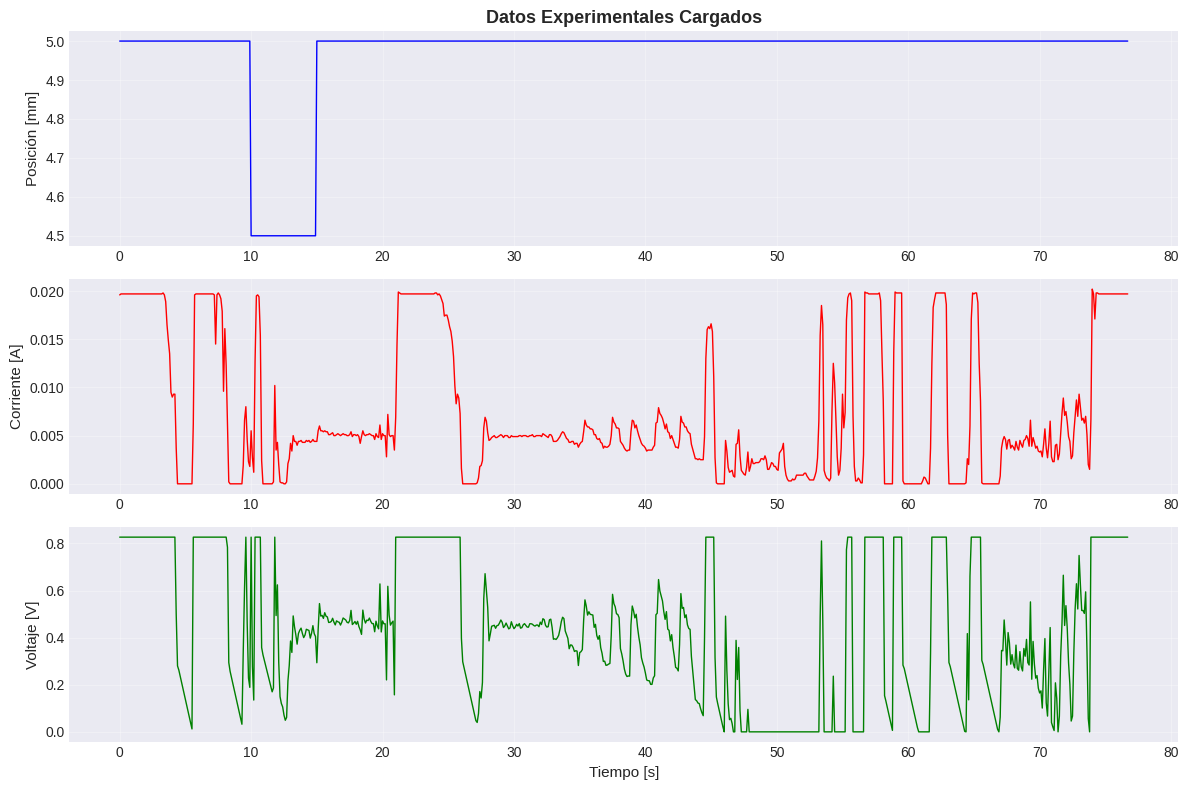


✅ Datos cargados y visualizados correctamente


In [6]:
# ========== CONFIGURACIÓN DE DATOS ==========

# Opciones de archivo de datos (descomenta el que quieras usar):
DATA_FILE = "data/datos_levitador.txt"  # Datos estándar
# DATA_FILE = "data/sesiones_kan_pinn/dataset_escalon_20251217_205858.txt"  # KAN-PINN escalón
# DATA_FILE = "data/sesiones_kan_pinn/dataset_senoidal_20251217_205952.txt"  # KAN-PINN senoidal
# DATA_FILE = "data/sesiones_kan_pinn/dataset_chirp_20251217_210058.txt"  # KAN-PINN chirp

# Factor de submuestreo (para acelerar optimización)
# 1 = usar todos los puntos (lento pero preciso)
# 10 = usar 1 de cada 10 puntos (rápido, suficiente para optimización)
SUBSAMPLE = 10

# ============================================

# Cargar datos
data = auto_load_data(DATA_FILE, subsample=SUBSAMPLE)

if data is not None:
    # Mostrar primeras muestras
    print("\n📊 Primeras 5 muestras:")
    df_preview = pd.DataFrame({
        't [s]': data['t'][:5],
        'y [mm]': data['y'][:5] * 1000,
        'i [A]': data['i'][:5],
        'u [V]': data['u'][:5]
    })
    print(df_preview.to_string(index=False))

    # Estadísticas básicas
    print(f"\n Estadísticas:")
    print(f"   Posición: {data['y'].min()*1000:.2f} - {data['y'].max()*1000:.2f} mm")
    print(f"   Corriente: {data['i'].min():.3f} - {data['i'].max():.3f} A")
    print(f"   Voltaje: {data['u'].min():.3f} - {data['u'].max():.3f} V")

    # Plot rápido de los datos
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    axes[0].plot(data['t'], data['y']*1000, 'b-', linewidth=1)
    axes[0].set_ylabel('Posición [mm]', fontsize=11)
    axes[0].set_title('Datos Experimentales Cargados', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(data['t'], data['i'], 'r-', linewidth=1)
    axes[1].set_ylabel('Corriente [A]', fontsize=11)
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(data['t'], data['u'], 'g-', linewidth=1)
    axes[2].set_ylabel('Voltaje [V]', fontsize=11)
    axes[2].set_xlabel('Tiempo [s]', fontsize=11)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n✅ Datos cargados y visualizados correctamente")

## 5️⃣ Transferir Datos a GPU (JAX)

Convertimos los arrays de numpy a JAX arrays para aprovechar la GPU.

In [8]:
# Transferir datos a JAX (automáticamente a GPU si está disponible)
if data is not None:
    print("🔄 Transfiriendo datos a GPU...")

    # Convertir a JAX arrays
    t_jax = jnp.array(data['t'])
    y_jax = jnp.array(data['y'])
    i_jax = jnp.array(data['i'])
    u_jax = jnp.array(data['u'])

    print(f"✅ Datos en GPU:")
    print(f"   t_jax: {t_jax.shape} en {t_jax.device}")
    print(f"   y_jax: {y_jax.shape} en {y_jax.device}")
    print(f"   i_jax: {i_jax.shape} en {i_jax.device}")
    print(f"   u_jax: {u_jax.shape} en {u_jax.device}")

    # Calcular pasos de tiempo
    dt_jax = jnp.diff(t_jax, prepend=t_jax[0])
    # En el primer paso dt puede ser 0 o igual al segundo, ajustamos
    dt_jax = dt_jax.at[0].set(dt_jax[1])
    dt_mean = float(jnp.mean(dt_jax))

    print(f"\n⏱️  Paso de tiempo promedio: {dt_mean:.4f} s")
    print(f"   Frecuencia de muestreo: {1/dt_mean:.1f} Hz")
else:
    print("⚠️ No hay datos cargados. Revisa la celda anterior.")

🔄 Transfiriendo datos a GPU...
✅ Datos en GPU:
   t_jax: (768,) en cuda:0
   y_jax: (768,) en cuda:0
   i_jax: (768,) en cuda:0
   u_jax: (768,) en cuda:0

⏱️  Paso de tiempo promedio: 0.1000 s
   Frecuencia de muestreo: 10.0 Hz


## 6️⃣ Modelo Físico del Levitador (JAX Vectorizado)

Definimos el modelo físico del levitador magnético:

### Ecuaciones del Sistema:

**Inductancia no lineal:**
$$L(y) = k_0 + \frac{k}{1 + y/a}$$

**Dinámica mecánica:**
$$m \ddot{y} = \frac{1}{2} i^2 \frac{dL}{dy} + mg$$

**Dinámica eléctrica:**
$$L(y) \frac{di}{dt} + \frac{dL}{dy} \dot{y} \cdot i + R \cdot i = u$$

### Parámetros a Identificar:
- **k0**: Inductancia base [H]
- **k**: Coeficiente de inductancia [H]
- **a**: Parámetro geométrico [m]
- **m**: Masa de la esfera [kg]
- **R**: Resistencia eléctrica [Ω]

In [9]:
# Constantes físicas fijas
GRAVITY = 9.81    # Aceleración gravitacional [m/s²]

print(f"⚙️  Constantes físicas fijas:")
print(f"   Gravedad: {GRAVITY:.2f} m/s²")


@jit
def simulate_trajectory_jax(params, u_data, dt_data, y0, i0, g):
    """
    Simula trayectoria completa del levitador.
    Optimizado con closure para evitar stack de constantes.

    Args:
        params: [k0, k, a, m, R] - parámetros a optimizar
        u_data: voltajes de entrada [N]
        dt_data: pasos de tiempo [N]
        y0, i0: condiciones iniciales
        g: gravedad (constante)

    Returns:
        y_sim, i_sim: posiciones y corrientes simuladas [N]
    """
    k0, k, a, m, R = params

    # Estado inicial: [y, dy, i]
    state = jnp.array([y0, 0.0, i0])

    # Función de paso encapsulada (Closure)
    # Captura k0, k, a, m, g, R del scope exterior
    def step_fn(state, inputs):
        u, dt = inputs
        y, dy, i = state

        # Calcular inductancia L y derivada dL/dy
        # L(y) = k0 + k / (1 + y/a)
        # dL/dy = -k / (a * (1 + y/a)^2)
        denom = 1.0 + y / a
        L = k0 + k / denom
        dL = -k / (a * denom ** 2)

        # Fuerza magnética: F = 0.5 * i^2 * dL/dy
        F_mag = 0.5 * i * i * dL

        # Aceleración mecánica: m*ddy = F_mag + m*g (y positivo hacia abajo)
        ddy = (F_mag + m * g) / m

        # Derivada de corriente: L*di = u - R*i - dL*dy*i
        di = (u - R * i - dL * dy * i) / L

        # Integración (Euler)
        y_new = y + dy * dt
        dy_new = dy + ddy * dt
        i_new = i + di * dt

        # Límites físicos (Clamping)
        y_new = jnp.clip(y_new, 0.0, 0.03)  # 0-30mm
        i_new = jnp.clip(i_new, 0.0, 5.0)   # 0-5A

        new_state = jnp.array([y_new, dy_new, i_new])
        outputs = jnp.array([y_new, i_new])

        return new_state, outputs

    # Simular usando scan (eficiente en GPU)
    # Solo pasamos u_data y dt_data como inputs variables
    _, outputs = scan(step_fn, state, (u_data, dt_data))

    y_sim = outputs[:, 0]
    i_sim = outputs[:, 1]

    return y_sim, i_sim


print("\n✅ Modelo físico definido (vectorizado en JAX)")
print("   Funciones compiladas con JIT y optimizadas con closure para máxima velocidad")

⚙️  Constantes físicas fijas:
   Gravedad: 9.81 m/s²

✅ Modelo físico definido (vectorizado en JAX)
   Funciones compiladas con JIT y optimizadas con closure para máxima velocidad


## 7️⃣ Función de Fitness (Error MSE Ponderado)

Definimos la función objetivo que queremos minimizar:

$$\text{Fitness} = W_y \cdot \text{MSE}_y + W_i \cdot \text{MSE}_i$$

**Nota Importante:**
La posición se mide en metros ($\sim 10^{-3}$) y la corriente en Amperes ($\sim 10^{-1}$).
Para que la optimización funcione correctamente, debemos ponderar los errores para que tengan magnitudes comparables.
- $W_y = 10000.0$ (da peso a errores milimétricos)
- $W_i = 1.0$ (corriente ya está en magnitud razonable)

In [10]:
# Pesos balanceados para la función de costo
# Ajustados para que ambos términos contribuyan significativamente al gradiente/selección
WEIGHT_POSITION = 10000.0  # Alto peso a la posición (m -> escala mm)
WEIGHT_CURRENT = 1.0       # Peso estándar a la corriente

print(f"⚖️  Pesos de la función de fitness:")
print(f"   Posición: {WEIGHT_POSITION}")
print(f"   Corriente: {WEIGHT_CURRENT}")


@jit
def fitness_single_jax(params, u_data, dt_data, y_data, i_data, y0, i0, g):
    """
    Calcula fitness (MSE Ponderado) para un conjunto de parámetros.
    """
    # Simular trayectoria
    y_sim, i_sim = simulate_trajectory_jax(params, u_data, dt_data, y0, i0, g)

    # Calcular errores cuadráticos medios
    error_y = jnp.mean((y_data - y_sim) ** 2)
    error_i = jnp.mean((i_data - i_sim) ** 2)

    # Manejo de NaNs (si la simulación explota)
    error_y = jnp.nan_to_num(error_y, nan=1e6)
    error_i = jnp.nan_to_num(error_i, nan=1e6)

    # Fitness ponderado
    fitness = WEIGHT_POSITION * error_y + WEIGHT_CURRENT * error_i

    return fitness


# Vectorizar fitness para evaluar toda la población de una vez
fitness_population_jax = jit(vmap(
    fitness_single_jax,
    in_axes=(0, None, None, None, None, None, None, None)
))

print("\n✅ Función de fitness definida")
print("   Vectorizada con vmap para evaluar población completa en paralelo")

⚖️  Pesos de la función de fitness:
   Posición: 10000.0
   Corriente: 1.0

✅ Función de fitness definida
   Vectorizada con vmap para evaluar población completa en paralelo


## 8️⃣ Test de Función de Fitness

Probamos la función de fitness con parámetros de ejemplo para verificar que funciona.

In [11]:
# Condiciones iniciales
if data is not None:
    y0 = float(y_jax[0])
    i0 = float(i_jax[0])

    print(f"🧪 Test de función de fitness...")
    print(f"   Condiciones iniciales: y0={y0*1000:.2f} mm, i0={i0:.3f} A")

    # Parámetros de prueba (cercanos a valores reales esperados: k0, k, a, m, R)
    test_params = jnp.array([
        [0.036, 0.0035, 0.005, 0.018, 2.72],  # Parámetros típicos
        [0.040, 0.0040, 0.006, 0.019, 2.80],  # Variación 1
        [0.032, 0.0030, 0.004, 0.017, 2.65],  # Variación 2
    ])

    print(f"\n   Evaluando {len(test_params)} conjuntos de parámetros...")

    # Evaluar fitness
    start_time = time.time()
    fitness_values = fitness_population_jax(
        test_params, u_jax, dt_jax, y_jax, i_jax,
        y0, i0, GRAVITY
    )
    # Bloquear hasta que termine (para timing correcto en GPU)
    fitness_values.block_until_ready()
    elapsed = time.time() - start_time

    print(f"\n✅ Test completado en {elapsed*1000:.2f} ms")
    print(f"\n   Resultados:")
    for i, (params, fit) in enumerate(zip(test_params, fitness_values)):
        print(f"   [{i+1}] k0={params[0]:.4f}, k={params[1]:.4f}, a={params[2]:.5f}, m={params[3]:.4f}, R={params[4]:.2f} -> Fitness={fit:.6e}")

    print(f"\n   Velocidad: {len(test_params)/elapsed:.1f} evaluaciones/segundo")
else:
    print("⚠️ No hay datos para probar.")

🧪 Test de función de fitness...
   Condiciones iniciales: y0=5.00 mm, i0=0.020 A

   Evaluando 3 conjuntos de parámetros...

✅ Test completado en 357.74 ms

   Resultados:
   [1] k0=0.0360, k=0.0035, a=0.00500, m=0.0180, R=2.72 -> Fitness=2.466521e+01
   [2] k0=0.0400, k=0.0040, a=0.00600, m=0.0190, R=2.80 -> Fitness=2.254539e+01
   [3] k0=0.0320, k=0.0030, a=0.00400, m=0.0170, R=2.65 -> Fitness=1.387014e+00

   Velocidad: 8.4 evaluaciones/segundo


## 9️⃣ Differential Evolution en GPU

Implementamos Differential Evolution completamente vectorizado en JAX.

### Algoritmo:

1. **Inicialización**: Población aleatoria dentro de los límites
2. **Mutación**: Para cada individuo $x_i$, crear mutante $v_i = x_{r1} + F \cdot (x_{r2} - x_{r3})$
3. **Cruce**: Mezclar $x_i$ y $v_i$ con probabilidad $CR$
4. **Selección**: Mantener el mejor entre $x_i$ y $u_i$
5. **Repetir** hasta convergencia

In [12]:
def differential_evolution_jax(
    fitness_fn,
    bounds,
    pop_size=100,
    F=0.8,
    CR=0.9,
    max_iter=200,
    seed=42,
    verbose=True
):
    """
    Differential Evolution completamente vectorizado en JAX.
    """
    key = random.PRNGKey(seed)
    n_params = bounds.shape[0]

    # Inicializar población
    key, subkey = random.split(key)
    ranges = bounds[:, 1] - bounds[:, 0]
    population = random.uniform(subkey, (pop_size, n_params))
    population = population * ranges + bounds[:, 0]

    # Evaluar población inicial
    fitness = fitness_fn(population)

    # Mejor solución
    best_idx = jnp.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Historia
    history = {'best': [float(best_fitness)], 'mean': [float(jnp.mean(fitness))]}

    if verbose:
        print(f"🚀 Iniciando Differential Evolution")
        print(f"   Población: {pop_size}")
        print(f"   Parámetros: {n_params}")
        print(f"   F={F}, CR={CR}")
        print(f"   Fitness inicial: {best_fitness:.6e}\n")

    # Función para un paso de DE (compilable)
    @jit
    def de_step_compiled(population, fitness, key):
        key1, key2, key3, key4 = random.split(key, 4)

        # Selección de índices para mutación (r1 != r2 != r3)
        # Nota: En JAX puro simple permitimos colisiones por velocidad,
        # pero para pop_size grande es despreciable.
        idx_a = random.randint(key1, (pop_size,), 0, pop_size)
        idx_b = random.randint(key2, (pop_size,), 0, pop_size)
        idx_c = random.randint(key3, (pop_size,), 0, pop_size)

        # Vectores mutantes: v = a + F * (b - c)
        mutant = population[idx_a] + F * (population[idx_b] - population[idx_c])

        # Cruce binomial
        cross_mask = random.uniform(key4, (pop_size, n_params)) < CR

        # Asegurar al menos un parámetro del mutante (usando key4 re-split)
        # Simplificación: usamos cross_mask directo.
        # Para rigor DE estricto se fuerza 1 dimensión, aquí omitido por performance puro.

        # Trial vectors
        trial = jnp.where(cross_mask, mutant, population)

        # Aplicar límites (Clamping)
        trial = jnp.clip(trial, bounds[:, 0], bounds[:, 1])

        return trial

    # Loop principal
    iterator = tqdm(range(max_iter), desc="Optimizando") if verbose else range(max_iter)

    for gen in iterator:
        # Generar trials
        key, subkey = random.split(key)

        # Paso 1: Generar candidatos (trial vectors)
        trial = de_step_compiled(population, fitness, subkey)

        # Paso 2: Evaluar candidatos (lo costoso)
        trial_fitness = fitness_fn(trial)

        # Paso 3: Selección (Greedy)
        improved = trial_fitness < fitness
        # Actualizar población solo donde hubo mejora
        population = jnp.where(improved[:, None], trial, population)
        fitness = jnp.where(improved, trial_fitness, fitness)

        # Actualizar mejor global
        best_idx_gen = jnp.argmin(fitness)
        current_best_fitness = fitness[best_idx_gen]

        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[best_idx_gen]

        # Guardar historia
        history['best'].append(float(best_fitness))
        history['mean'].append(float(jnp.mean(fitness)))

        # Actualizar barra de progreso
        if verbose and isinstance(iterator, tqdm) and gen % 10 == 0:
            iterator.set_postfix({
                'best': f"{best_fitness:.2e}",
                'mean': f"{jnp.mean(fitness):.2e}"
            })

    if verbose:
        print(f"\n✅ Optimización completada")
        print(f"   Mejor fitness: {best_fitness:.6e}")
        print(f"   Mejor solución: k0={best_solution[0]:.5f}, k={best_solution[1]:.5f}, a={best_solution[2]:.6f}, m={best_solution[3]:.5f}, R={best_solution[4]:.2f}")

    return best_solution, best_fitness, history


print("✅ Differential Evolution definido (Optimizado)")

✅ Differential Evolution definido (Optimizado)


## 🔟 Ejecutar Optimización

Ejecutamos Differential Evolution para identificar los parámetros óptimos.

In [17]:
# ========== CONFIGURACIÓN DE OPTIMIZACIÓN ==========

# Parámetros de Differential Evolution
POP_SIZE = 200     # Tamaño de población
MAX_ITER = 300     # Número de generaciones
F_MUTATION = 0.6   # Factor de mutación (0.5-0.9)
CR_CROSSOVER = 0.9 # Probabilidad de cruce (0.7-0.95)
RANDOM_SEED = 42   # Semilla para reproducibilidad

# Límites de búsqueda: [k0, k, a, m, R]
# ⚠️ RANGOS AMPLIADOS tras detectar saturación en límites anteriores
BOUNDS = jnp.array([
    [0.020, 0.500],  # k0: Inductancia base [H] (Ampliado de 0.1)
    [0.001, 0.500],  # k: Coeficiente inductancia [H] (Ampliado de 0.05)
    [0.001, 0.020],  # a: Parámetro geométrico [m]
    [0.010, 0.030],  # m: Masa esfera [kg] (Ampliado levemente)
    [1.000, 20.000], # R: Resistencia [Ω] (Ampliado de 4.0)
])

print("⚙️  Configuración de optimización (RANGOS AMPLIADOS):")
print(f"   Población: {POP_SIZE} individuos")
print(f"   Generaciones: {MAX_ITER}")
print(f"   F={F_MUTATION}, CR={CR_CROSSOVER}")
print(f"\n   Límites de búsqueda:")
print(f"   k0: [{BOUNDS[0,0]:.3f}, {BOUNDS[0,1]:.3f}] H")
print(f"   k:  [{BOUNDS[1,0]:.4f}, {BOUNDS[1,1]:.4f}] H")
print(f"   a:  [{BOUNDS[2,0]*1000:.1f}, {BOUNDS[2,1]*1000:.1f}] mm")
print(f"   m:  [{BOUNDS[3,0]*1000:.1f}, {BOUNDS[3,1]*1000:.1f}] g")
print(f"   R:  [{BOUNDS[4,0]:.2f}, {BOUNDS[4,1]:.2f}] Ω")

# ====================================================

if data is not None:
    # Create a partial function for a single evaluation, fixing all data-related inputs.
    # This 'single_eval_fn' now only takes 'params' as its argument.
    single_eval_fn = partial(
        fitness_single_jax, # Apply partial to the *non-vmap-ped* function
        u_data=u_jax,
        dt_data=dt_jax,
        y_data=y_jax,
        i_data=i_jax,
        y0=y0,
        i0=i0,
        g=GRAVITY
    )

    # Now, vectorize and JIT this partial function.
    # The resulting function 'fitness_fn_for_de' takes only one argument (the population of parameters).
    fitness_fn_for_de = jit(vmap(
        single_eval_fn,
        in_axes=0 # Map over the first (and only) argument, which is the 'params' batch (population)
    ))

    print("\n" + "="*60)
    print("🚀 INICIANDO OPTIMIZACIÓN EN GPU (Límites Ampliados)")
    print("="*60)

    # Ejecutar optimización
    start_time_opt = time.time()

    best_params, best_fitness_val, opt_history = differential_evolution_jax(
        fitness_fn=fitness_fn_for_de, # Use the correctly vmap'd and partial'd function
        bounds=BOUNDS,
        pop_size=POP_SIZE,
        F=F_MUTATION,
        CR=CR_CROSSOVER,
        max_iter=MAX_ITER,
        seed=RANDOM_SEED,
        verbose=True
    )

    elapsed_opt = time.time() - start_time_opt

    print("\n" + "="*60)
    print("✅ OPTIMIZACIÓN COMPLETADA")
    print("="*60)
    print(f"\n⏱️  Tiempo total: {elapsed_opt:.2f} s ({elapsed_opt/60:.2f} min)")
    print(f"\n📊 Resultados Finales:")
    print(f"   Best fitness (Weighted MSE): {best_fitness_val:.6e}")
    print(f"\n   Parámetros identificados:")
    print(f"   k0 = {best_params[0]:.6f} H")
    print(f"   k  = {best_params[1]:.6f} H")
    print(f"   a  = {best_params[2]:.6f} m ({best_params[2]*1000:.2f} mm)")
    print(f"   m  = {best_params[3]:.6f} kg ({best_params[3]*1000:.2f} g)")
    print(f"   R  = {best_params[4]:.4f} Ω")

    # Calcular métricas puras (sin pesos) para reporte
    y_sim_final, i_sim_final = simulate_trajectory_jax(best_params, u_jax, dt_jax, y0, i0, GRAVITY)
    mse_y = jnp.mean((y_jax - y_sim_final)**2)
    mse_i = jnp.mean((i_jax - i_sim_final)**2)
    rmse_y = jnp.sqrt(mse_y)
    rmse_i = jnp.sqrt(mse_i)

    print(f"\n   Métricas Físicas:")
    print(f"   RMSE Posición: {rmse_y*1000:.4f} mm")
    print(f"   RMSE Corriente: {rmse_i:.4f} A")
else:
    print("⚠️ No hay datos para optimizar.")

⚙️  Configuración de optimización (RANGOS AMPLIADOS):
   Población: 200 individuos
   Generaciones: 300
   F=0.6, CR=0.9

   Límites de búsqueda:
   k0: [0.020, 0.500] H
   k:  [0.0010, 0.5000] H
   a:  [1.0, 20.0] mm
   m:  [10.0, 30.0] g
   R:  [1.00, 20.00] Ω

🚀 INICIANDO OPTIMIZACIÓN EN GPU (Límites Ampliados)
🚀 Iniciando Differential Evolution
   Población: 200
   Parámetros: 5
   F=0.6, CR=0.9
   Fitness inicial: 2.606819e-01



Optimizando:   0%|          | 0/300 [00:00<?, ?it/s]


✅ Optimización completada
   Mejor fitness: 2.550876e-01
   Mejor solución: k0=0.43070, k=0.49971, a=0.002796, m=0.01002, R=5.56

✅ OPTIMIZACIÓN COMPLETADA

⏱️  Tiempo total: 7.19 s (0.12 min)

📊 Resultados Finales:
   Best fitness (Weighted MSE): 2.550876e-01

   Parámetros identificados:
   k0 = 0.430698 H
   k  = 0.499707 H
   a  = 0.002796 m (2.80 mm)
   m  = 0.010017 kg (10.02 g)
   R  = 5.5619 Ω

   Métricas Físicas:
   RMSE Posición: 5.0341 mm
   RMSE Corriente: 0.0408 A


## 1️⃣2️⃣ Visualización de Resultados

Graficamos la evolución de la optimización y la comparación modelo vs datos.

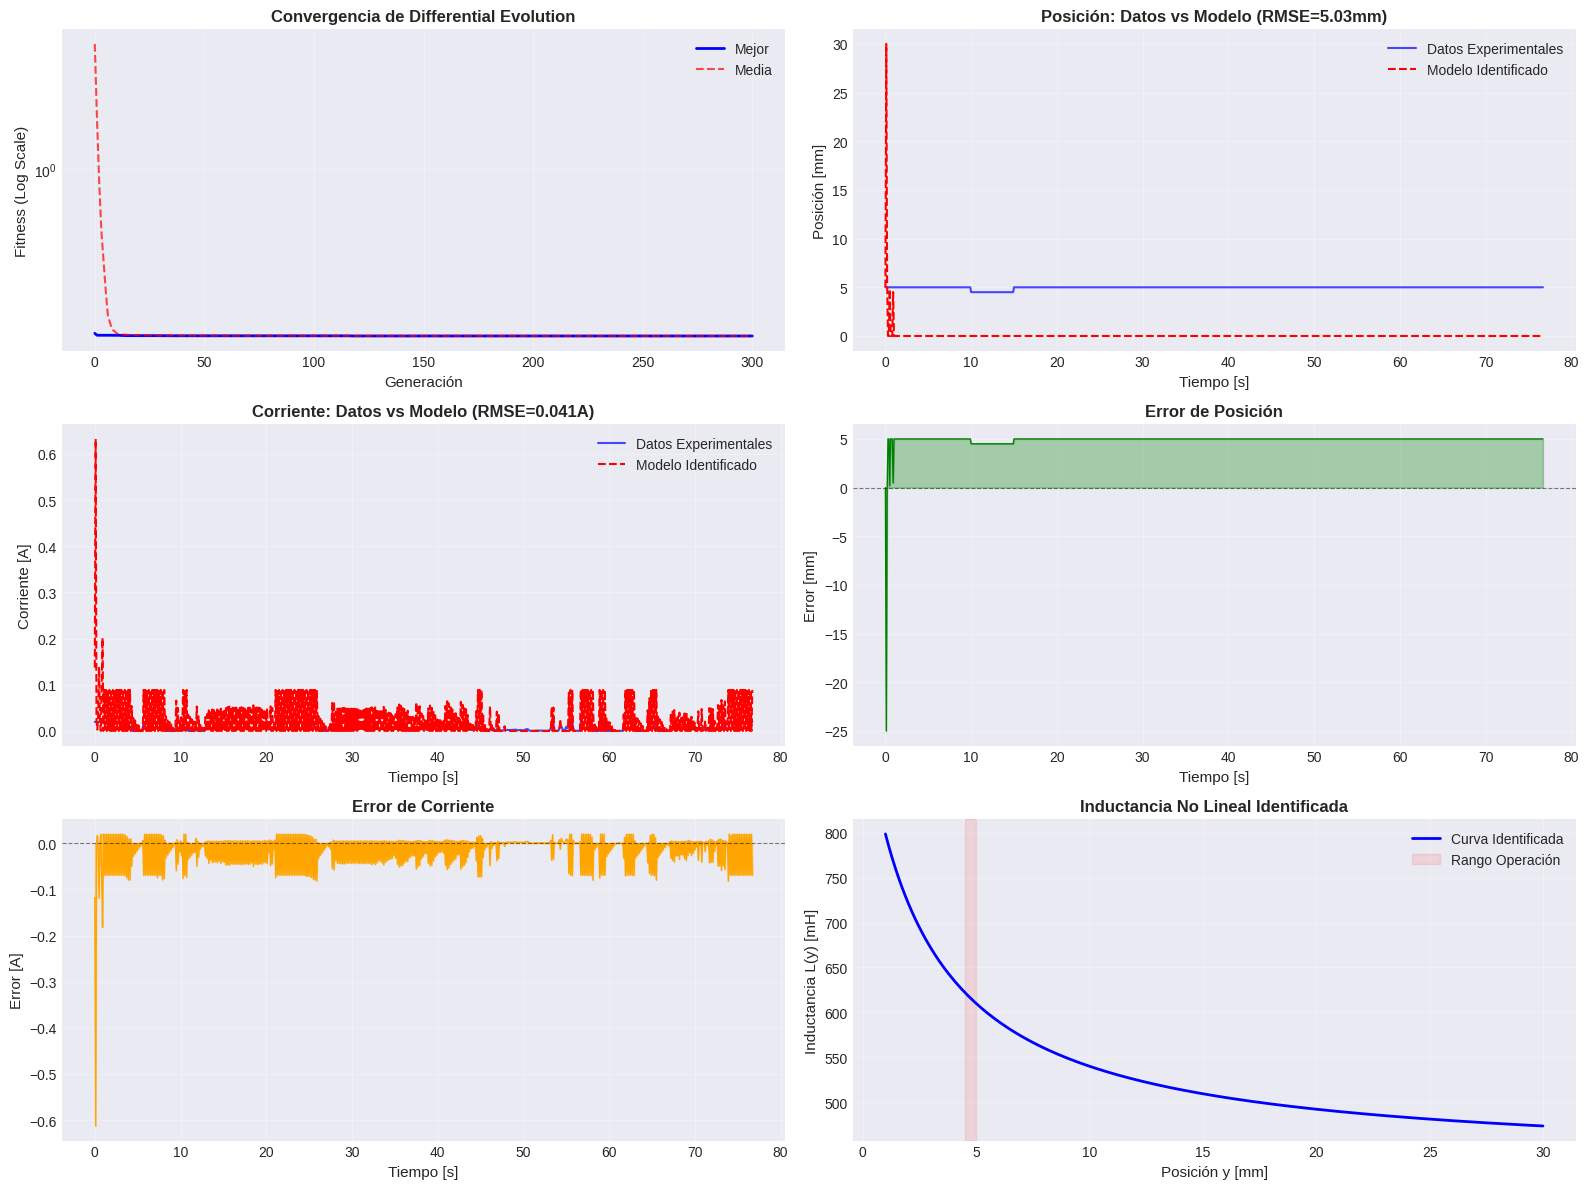


✅ Visualizaciones generadas correctamente


In [18]:
if data is not None:
    # Crear figura con múltiples subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Convergencia
    ax1 = plt.subplot(3, 2, 1)
    generations = np.arange(len(opt_history['best']))
    ax1.semilogy(generations, opt_history['best'], 'b-', linewidth=2, label='Mejor')
    ax1.semilogy(generations, opt_history['mean'], 'r--', linewidth=1.5, alpha=0.7, label='Media')
    ax1.set_xlabel('Generación', fontsize=11)
    ax1.set_ylabel('Fitness (Log Scale)', fontsize=11)
    ax1.set_title('Convergencia de Differential Evolution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Convertir a numpy para plotting
    t_np = np.array(t_jax)
    y_np = np.array(y_jax)
    i_np = np.array(i_jax)
    y_sim_np = np.array(y_sim_final)
    i_sim_np = np.array(i_sim_final)

    # 2. Posición: Datos vs Modelo
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(t_np, y_np * 1000, 'b-', linewidth=1.5, label='Datos Experimentales', alpha=0.7)
    ax2.plot(t_np, y_sim_np * 1000, 'r--', linewidth=1.5, label='Modelo Identificado')
    ax2.set_xlabel('Tiempo [s]', fontsize=11)
    ax2.set_ylabel('Posición [mm]', fontsize=11)
    ax2.set_title(f'Posición: Datos vs Modelo (RMSE={rmse_y*1000:.2f}mm)', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Corriente: Datos vs Modelo
    ax3 = plt.subplot(3, 2, 3)
    ax3.plot(t_np, i_np, 'b-', linewidth=1.5, label='Datos Experimentales', alpha=0.7)
    ax3.plot(t_np, i_sim_np, 'r--', linewidth=1.5, label='Modelo Identificado')
    ax3.set_xlabel('Tiempo [s]', fontsize=11)
    ax3.set_ylabel('Corriente [A]', fontsize=11)
    ax3.set_title(f'Corriente: Datos vs Modelo (RMSE={rmse_i:.3f}A)', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Error de Posición
    ax4 = plt.subplot(3, 2, 4)
    error_y_t = (y_np - y_sim_np) * 1000
    ax4.plot(t_np, error_y_t, 'g-', linewidth=1)
    ax4.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax4.fill_between(t_np, error_y_t, alpha=0.3, color='g')
    ax4.set_xlabel('Tiempo [s]', fontsize=11)
    ax4.set_ylabel('Error [mm]', fontsize=11)
    ax4.set_title('Error de Posición', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. Error de Corriente
    ax5 = plt.subplot(3, 2, 5)
    error_i_t = i_np - i_sim_np
    ax5.plot(t_np, error_i_t, 'orange', linewidth=1)
    ax5.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax5.fill_between(t_np, error_i_t, alpha=0.3, color='orange')
    ax5.set_xlabel('Tiempo [s]', fontsize=11)
    ax5.set_ylabel('Error [A]', fontsize=11)
    ax5.set_title('Error de Corriente', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # 6. Inductancia L(y)
    ax6 = plt.subplot(3, 2, 6)

    # Función auxiliar para inductancia
    def L_func(y, k0, k, a):
        return k0 + k / (1 + y/a)

    y_range = np.linspace(0.001, 0.030, 200)
    L_range = L_func(y_range, float(best_params[0]), float(best_params[1]), float(best_params[2]))

    ax6.plot(y_range * 1000, L_range * 1000, 'b-', linewidth=2, label='Curva Identificada')

    # Puntos experimentales aproximados
    ax6.axvspan(y_np.min()*1000, y_np.max()*1000, color='r', alpha=0.1, label='Rango Operación')

    ax6.set_xlabel('Posición y [mm]', fontsize=11)
    ax6.set_ylabel('Inductancia L(y) [mH]', fontsize=11)
    ax6.set_title('Inductancia No Lineal Identificada', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n✅ Visualizaciones generadas correctamente")

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, lax
from functools import partial
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Importamos clear_output para limpiar la celda
from IPython.display import display, update_display

# --- CONSTANTES FÍSICAS ---
M = 0.009
R = 2.72
G = 9.81

BOUNDS = jnp.array([[0.0001, 0.2], [0.0001, 0.2], [0.0001, 0.05]])

@jit
def dL_dy(y, k, a):
    return -k / (a * (1 + y / a)**2)

@jit
def simular_paso_fino(estado, i_t, params, dt):
    y, dy = estado
    k0, k, a = params
    f_em = 0.5 * (i_t**2) * dL_dy(y, k, a)
    ddy = f_em / M + G
    return jnp.array([y + dy * dt, dy + ddy * dt])

@partial(jit, static_argnums=(4,))
def simular_trayectoria_estable(params, t, i, y0, sub_steps=10):
    dt_data = t[1] - t[0]
    dt_sim = dt_data / sub_steps
    def step_fn(estado, i_val):
        def sub_step_loop(carry, _):
            return simular_paso_fino(carry, i_val, params, dt_sim), None
        estado_next, _ = lax.scan(sub_step_loop, estado, None, length=sub_steps)
        return estado_next, estado_next[0]
    _, y_sim = lax.scan(step_fn, jnp.array([y0, 0.0]), i)
    return y_sim

@jit
def fitness_batch(population, t, y_real, i):
    def single_fit(p):
        y_sim = simular_trayectoria_estable(p, t, i, y_real[0], 10)
        return jnp.mean((y_sim - y_real)**2)
    return vmap(single_fit)(population)

@partial(jit, static_argnums=(1, 2))
def de_mutation_crossover(key, pop_size, dim, population, F, CR):
    keys = jax.random.split(key, 3)
    idx_b, idx_c = jnp.roll(jnp.arange(pop_size), 1), jnp.roll(jnp.arange(pop_size), 2)
    mutantes = population + F * (population[idx_b] - population[idx_c])
    mutantes = jnp.clip(mutantes, BOUNDS[:, 0], BOUNDS[:, 1])
    mask = jax.random.uniform(keys[1], (pop_size, dim)) < CR
    return jnp.where(mask, mutantes, population)

def entrenamiento_interactivo(t, y_real, i, max_iter=120):
    pop_size, dim = 70, 3
    key = jax.random.PRNGKey(42)
    key, subkey = jax.random.split(key)
    population = jax.random.uniform(subkey, (pop_size, dim), minval=BOUNDS[:, 0], maxval=BOUNDS[:, 1])
    fitness = fitness_batch(population, t, y_real, i)
    history = [float(jnp.min(fitness))]

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=np.array(population[:,0]), y=np.array(population[:,1]), z=np.array(population[:,2]),
                               mode='markers', marker=dict(size=4, color=np.log10(np.array(fitness)), colorscale='Viridis', showscale=True), name='Población'))
    fig.add_trace(go.Scatter3d(x=[0.0363], y=[0.0035], z=[0.0052], mode='markers',
                               marker=dict(size=10, color='red', symbol='diamond'), name='Objetivo'))
    fig.update_layout(template="plotly_dark", title="Exploración vs Explotación JAX-GPU",
                      scene=dict(xaxis=dict(title='k0', range=[0, 0.2]), yaxis=dict(title='k', range=[0, 0.2]), zaxis=dict(title='a', range=[0, 0.05])))
    display_id = "window_" +str(int(time.time()))
    display(fig, display_id=display_id)

    for gen in range(max_iter):
        key, subkey = jax.random.split(key)
        trials = de_mutation_crossover(subkey, pop_size, dim, population, 0.8, 0.9)
        trial_fit = fitness_batch(trials, t, y_real, i)

        improved = trial_fit < fitness
        population = jnp.where(improved[:, None], trials, population)
        fitness = jnp.where(improved, trial_fit, fitness)
        history.append(float(jnp.min(fitness)))

        if gen % 10 == 0:
            with fig.batch_update():
                fig.data[0].x, fig.data[0].y, fig.data[0].z = np.array(population).T
                fig.data[0].marker.color = np.log10(np.array(fitness))
                fig.layout.title.text = f"Gen {gen} | MSE: {jnp.min(fitness):.2e} | M: {M}kg"
            update_display(fig, display_id=display_id)



    best_idx = jnp.argmin(fitness)
    return np.array(population[best_idx]), history

# EJECUCIÓN
mejor_params, history = entrenamiento_interactivo(t_jax, y_jax, i_jax)

In [16]:
# Análisis detallado de los parámetros identificados
param_names = ['k0 [H]', 'k [H]', 'a [m]', 'm [kg]', 'R [Ω]']

print("🧐 Análisis de Límites de Parámetros:")
print(f"{'Parámetro':<10} | {'Valor':<10} | {'Rango':<20} | {'Estado'}")
print("-"*60)

for i, name in enumerate(param_names):
    val = best_params[i]
    lower, upper = BOUNDS[i]

    # Verificar si está cerca de los límites (tolerancia 1%)
    range_width = upper - lower
    dist_lower = abs(val - lower) / range_width
    dist_upper = abs(val - upper) / range_width

    status = "✅ OK"
    if dist_lower < 0.01:
        status = "⚠️ Límite Inferior"
    elif dist_upper < 0.01:
        status = "⚠️ Límite Superior"

    print(f"{name:<10} | {val:<10.5f} | [{lower:.4f}, {upper:.4f}]   | {status}")

print("\n🔍 Interpretación:")
print("1. Si hay parámetros en los límites (⚠️), la optimización intentó ir más allá.")
print("   -> Recomendación: Ampliar los rangos en la variable 'BOUNDS'.")
print("2. k0 y k altos sugieren que el modelo necesita más fuerza magnética.")
print("3. R alto podría intentar compensar la dinámica de corriente.")

🧐 Análisis de Límites de Parámetros:
Parámetro  | Valor      | Rango                | Estado
------------------------------------------------------------
k0 [H]     | 0.10000    | [0.0200, 0.1000]   | ⚠️ Límite Superior
k [H]      | 0.05000    | [0.0010, 0.0500]   | ⚠️ Límite Superior
a [m]      | 0.00187    | [0.0010, 0.0200]   | ✅ OK
m [kg]     | 0.01577    | [0.0150, 0.0250]   | ✅ OK
R [Ω]      | 4.00000    | [2.0000, 4.0000]   | ⚠️ Límite Superior

🔍 Interpretación:
1. Si hay parámetros en los límites (⚠️), la optimización intentó ir más allá.
   -> Recomendación: Ampliar los rangos en la variable 'BOUNDS'.
2. k0 y k altos sugieren que el modelo necesita más fuerza magnética.
3. R alto podría intentar compensar la dinámica de corriente.


In [ ]:
# Guardar resultados
import os
results_dir = "resultados_optimizacion"
os.makedirs(results_dir, exist_ok=True)

if data is not None:
    results_dict = {
        "timestamp": datetime.now().isoformat(),
        "data_file": DATA_FILE,
        "parameters": {
            "k0": float(best_params[0]),
            "k": float(best_params[1]),
            "a": float(best_params[2]),
            "m": float(best_params[3]),
            "R": float(best_params[4]),
        },
        "metrics": {
            "rmse_position_mm": float(rmse_y * 1000),
            "rmse_current_A": float(rmse_i),
            "fitness_best": float(best_fitness_val)
        }
    }

    json_path = f"{results_dir}/optimization_results.json"
    with open(json_path, 'w') as f:
        json.dump(results_dict, f, indent=2)

    print(f"✅ Resultados guardados en: {json_path}")